In [86]:
#For generating error in sinusoidal fitting
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import center_of_mass
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
import matplotlib
import sunpy.visualization.colormaps as cm
import os
import pandas as pd
import configparser as cfg
from uncertainties import ufloat

def gaussian(x,A,mu,sigma,const):
    return(A*np.exp(-(x-mu)**2/(2*sigma**2))+const)

def sinusoid(t,Am,P,phi,k,Ao):
    return(Am*np.sin(2*np.pi*t/P+phi)+k*t+Ao)

def find_peak(y,dy):
    # making the slice of compatible dimension
    y=y[::,0]
    dy=dy[::,0]
    l=len(y)
    x=np.arange(0,l)
    com=center_of_mass(y)[0]
    avg=np.average(y)
    maxi=np.argmax(y)
    #std=np.std(y)
    std=l/6
    try:
        parameters,pcov = curve_fit(gaussian, x, y,p0=[com,maxi,std,avg],sigma=dy,absolute_sigma=True)
        # parameters,pcov = curve_fit(gaussian, x, y,p0=[com,maxi,std,avg])
        fit_y=gaussian(x,parameters[0],parameters[1],parameters[2],parameters[3])
        index_max=np.argmax(fit_y)
        if 0<parameters[2]<1:
            parameters[2]=1
        if 1<parameters[2]<l and 0<parameters[1]<l-1:
            # return(index_max)
            return(parameters[1],parameters[2])
    except RuntimeError:
        pass

def chi_squared(expected,observed,sigma):
    chi=0
    for i in range(len(expected)):
        chi+=(expected[i]-observed[i])**2/(sigma[i])**2
    return(chi)

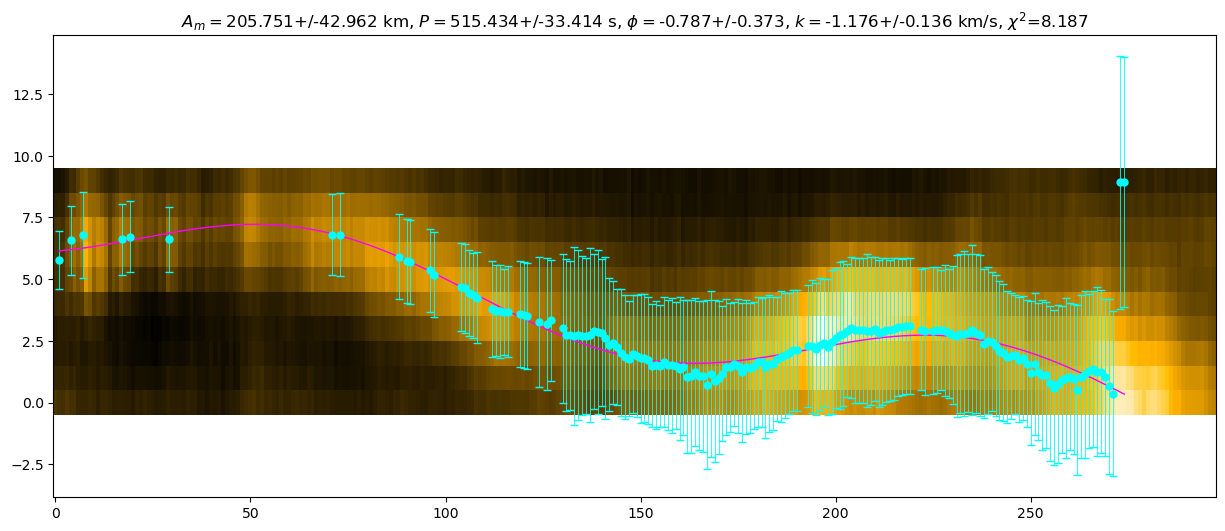

In [87]:
# directory=input("Enter the path of the slits: ")+"/"

directory="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R2/Slits/S9/L1/"

# config_file=directory+"units.cfg"
config_file="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/codes/test_data/S3/units.cfg"
config=cfg.ConfigParser()
config.read(config_file)

cadence=eval(config['PHYSICAL UNITS']['cadence'])
scale=eval(config['PHYSICAL UNITS']['scale'])

exposure=eval(config['IMAGE']['EXPOSURE'])

data = np.loadtxt(directory+"xt_map.csv",delimiter=",", dtype=float)
data_err=np.sqrt(np.loadtxt(directory+"xt_map.csv",delimiter=",", dtype=float)*exposure*6.85+2)
#data = np.loadtxt(directory+"xt_map_smooth_201.csv",delimiter=",", dtype=float).T

cmap=matplotlib.colormaps['sdoaia171']

#plt.imshow(data.T,origin='lower',cmap=cmap)
#plt.imshow(data_err.T,origin='lower',cmap=cmap)


# breaking the xt-map in slices then fitting gaussian on each slice
slices=np.hsplit(data,len(data[0]))
slices_err=np.hsplit(data_err,len(data_err[0]))
peak=[]
peak_err=[]
t=[]

for i in range(len(slices)):
    peak_data=find_peak(slices[i],slices_err[i])
    if peak_data!=None:
        t.append(i)
        peak.append(peak_data[0])
        # peak_err.append(peak_data[1])
        peak_err.append(peak_data[1])
        plt.show()
# print(peak,peak_err)
# plt.errorbar(t,peak,yerr=peak_err,fmt='o')
# plt.show()
guess_amplitude=np.max(peak)-np.mean(peak)
#periods=np.linspace(eval(input("Enter period start: ")),eval(input("Enter period end: ")),1000)
periods=np.linspace(1,2000,1000)
pgram=lombscargle(t,peak,periods)
# plt.plot(periods,pgram)
# plt.show()
guess_period=periods[np.argmax(pgram)]
# guess_period=280
guess_phase=0
guess_offset=np.mean(peak)
guess_drift=(peak[-1]-peak[0])/len(peak)
guess=[guess_amplitude,guess_period,guess_phase,guess_drift,guess_offset]
t_fit=np.linspace(t[0],t[-1],10*len(t))

try:
    sine_param,sine_cov=curve_fit(sinusoid,t,peak,p0=guess,sigma=peak_err,absolute_sigma=True)
    sine_err=np.sqrt(np.diag(sine_cov))

    Am=ufloat(sine_param[0],sine_err[0])*scale
    P=ufloat(sine_param[1],sine_err[1])*cadence
    phi=ufloat(sine_param[2],sine_err[2])
    k=ufloat(sine_param[3],sine_err[3])*scale/cadence
    Ao=ufloat(sine_param[3],sine_err[3])*scale

except RuntimeError:
    print("Sinusoidal fit did not converge")

fig=plt.figure(figsize=(15,6))
plt.imshow(data,origin='lower',cmap=cmap,aspect='auto')
plt.errorbar(t,peak,yerr=peak_err,color='cyan',markersize=5,fmt='o',lw=0.6,capsize=3)
try:
    sine=sinusoid(t_fit,sine_param[0],sine_param[1],sine_param[2],sine_param[3],sine_param[4])
    observed=sinusoid(np.array(t),sine_param[0],sine_param[1],sine_param[2],sine_param[3],sine_param[4])
    plt.plot(t_fit,sine,color='magenta',linewidth=1)
    chi_sq=chi_squared(peak,observed,peak_err)
    # plt.title(r"$A_m=$%.3f km, $P=$%.3f s, $\phi=$%.3f, $k=$%.3f km/s, $\chi^2$=%.3f"%(abs(sine_param[0]*scale),sine_param[1]*cadence,sine_param[2],sine_param[3]*scale/cadence,chi_sq))
    plt.title(rf"$A_m=${Am:.3f} km, $P=${P:.3f} s, $\phi=${phi:.3f}, $k=${k:.3f} km/s, $\chi^2$={chi_sq:.3f}")
#    plt.savefig(directory+f"xt_map_fit.png",dpi=300)
except NameError:
    print("Can't plot Sinusoidal parameters not found!")
plt.show()

    # toggle_1=int(input("Enter 1 to save oscillation, 0 to skip: "))
    # if toggle_1==0:
    #     pass
    # if toggle_1==1:
    #     loop_name=input("Enter loop name: ")
    #     #loop_name="L"+f"{loop_number}"
    #     save_path=directory+loop_name+"/"
    #     os.makedirs(save_path)
    #     np.savetxt(save_path+"xt_map.csv",data_osci,delimiter=',')
    #     df_loop_center=pd.DataFrame({"Frame":t,"Peak center":peak})
    #     df_loop_center.to_csv(save_path+"loop_center.csv",index=False)
    #     df_box_loc=pd.DataFrame({"x":[left,right],"y":[bottom,top]})
    #     df_box_loc.to_csv(save_path+"box_location.csv",index=False)
    #     fig.savefig(save_path+"oscillation.png",dpi=300)
    #     df_oscillation_parameter=pd.DataFrame({"Amplitude [km]":[sine_param[0]*scale],"Period [s]":[sine_param[1]*cadence],"Drift Velocity [km/s]":[sine_param[3]*scale/cadence],"Phase":[sine_param[2]],"Off-set":[sine_param[4]*scale],"Chi-squared [pixel]":[chi_sq]})
    #     df_oscillation_parameter.to_csv(save_path+"oscillation_parameter.csv",index=False)
    # toggle=int(input("Enter 1 to re-run the code, 0 to end the code: "))

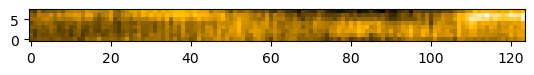

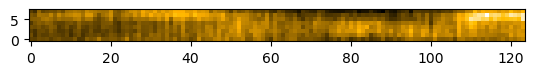

In [10]:
plt.imshow(data_err.T,origin='lower',cmap=cmap)
plt.show()
plt.imshow(data.T,origin='lower',cmap=cmap)
plt.show()

In [9]:
a='120+/-20'

In [10]:
b=ufloat(a)

/tmp/ipykernel_164843/3274304884.py:1: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  b=ufloat(a)


In [12]:
print(type(b))

<class 'uncertainties.core.Variable'>


In [27]:
#convert all the xt_map to correct power while making powers were reduced by 0.04 by mistake
import numpy as np
import glob

slit_folders="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/codes/oscillations_revision_3/S*/"
slits=glob.glob(slit_folders)

for slit in slits:
    loop_folders=slit+"/L*"
    loops=glob.glob(loop_folders)
    for loop in loops:
        xt_map_path=loop+"/xt_map.csv"
        xt_map = np.loadtxt(xt_map_path,delimiter=",", dtype=float).T
        xt_map_new=xt_map**(1/0.04)
        np.savetxt(xt_map_path,xt_map,delimiter=',')

In [31]:
import pandas as pd
save_path="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/codes/test_data"

a=ufloat(2,0.1)
b=ufloat(5,0.1)

dictionary={'a':[a],'b':[b]}
df=pd.DataFrame(data=dictionary)
df.to_csv(save_path+"/test.csv",index=False)

In [43]:
test_file="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/codes/test_data/test.csv"
df=pd.read_csv(test_file,sep=',',header=0,names=['a','b'])
a=ufloat(df['a'][0])

/tmp/ipykernel_25181/2780617002.py:3: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  a=ufloat(df['a'][0])


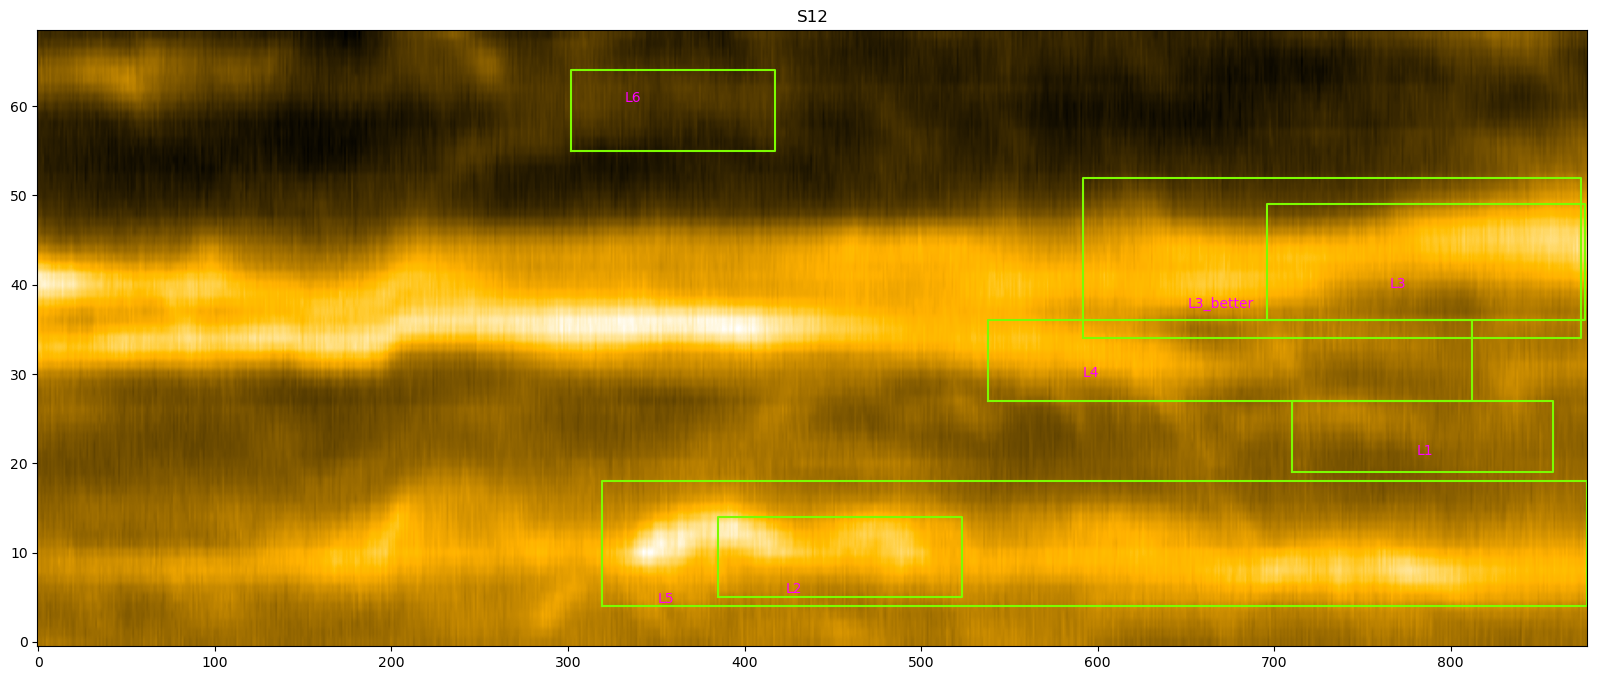

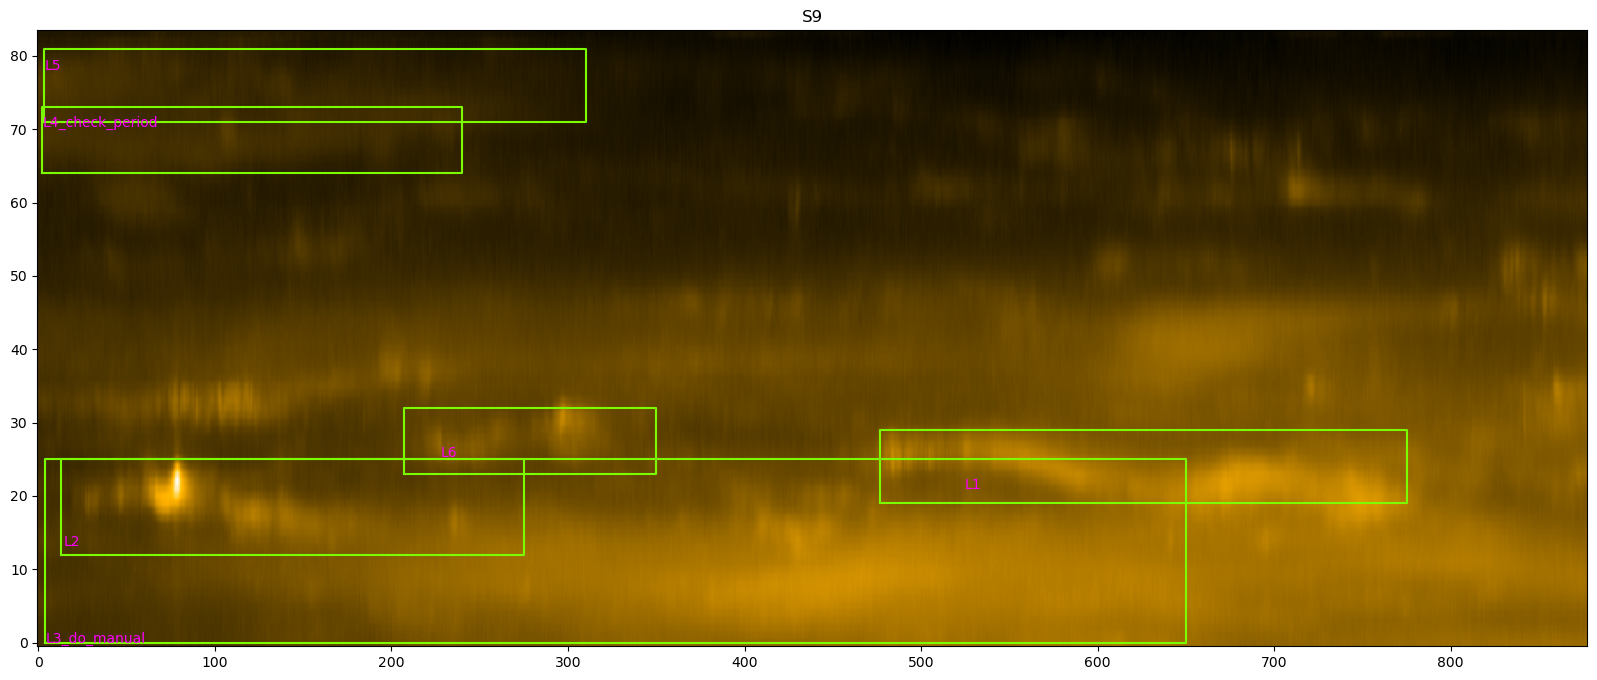

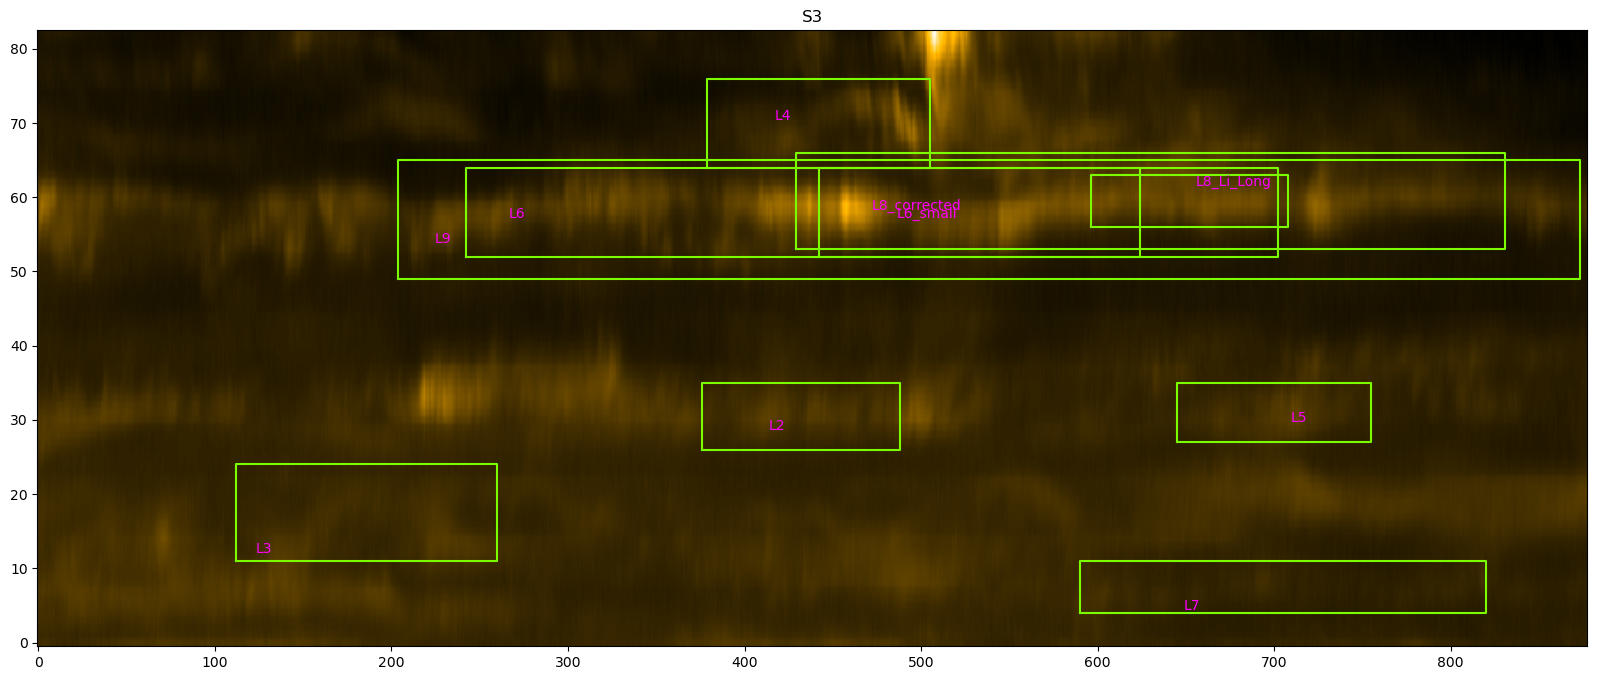

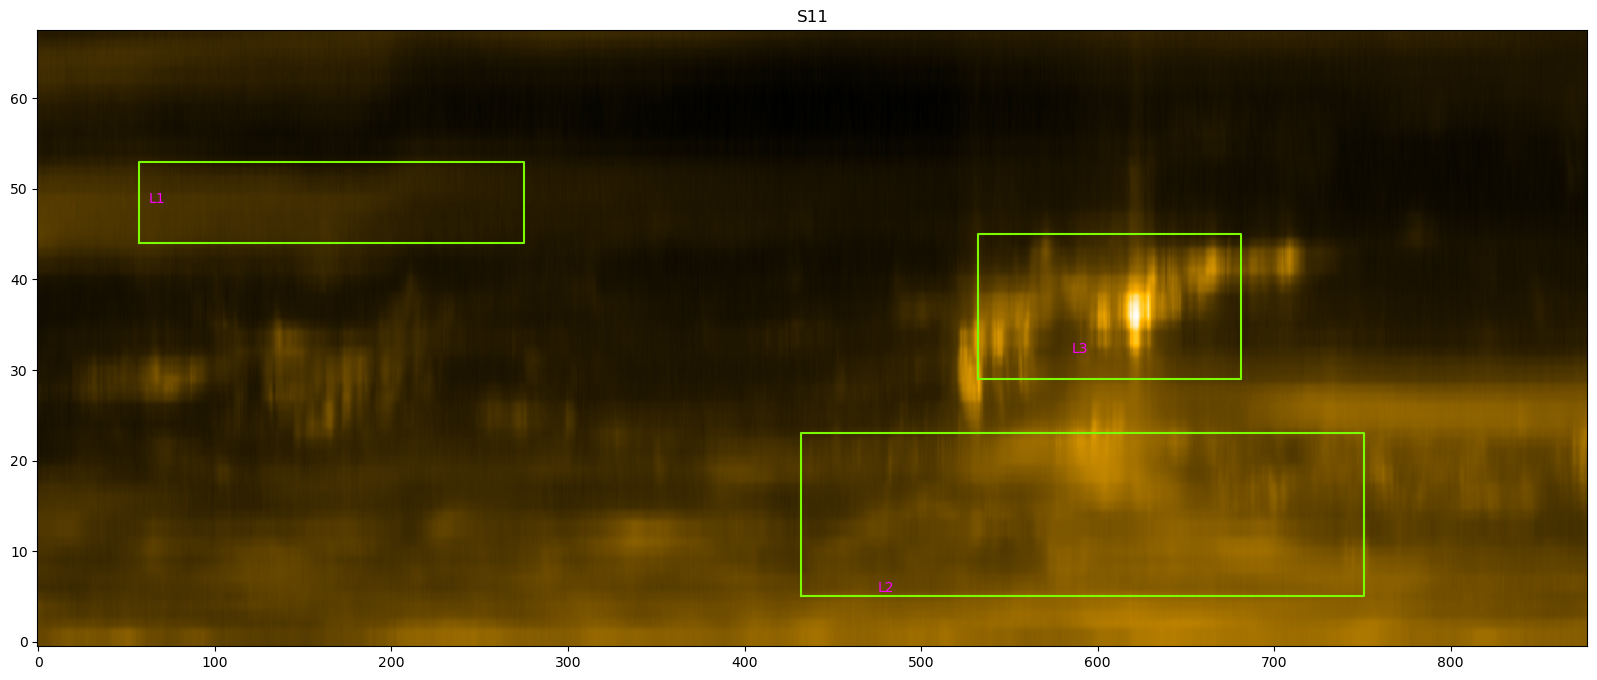

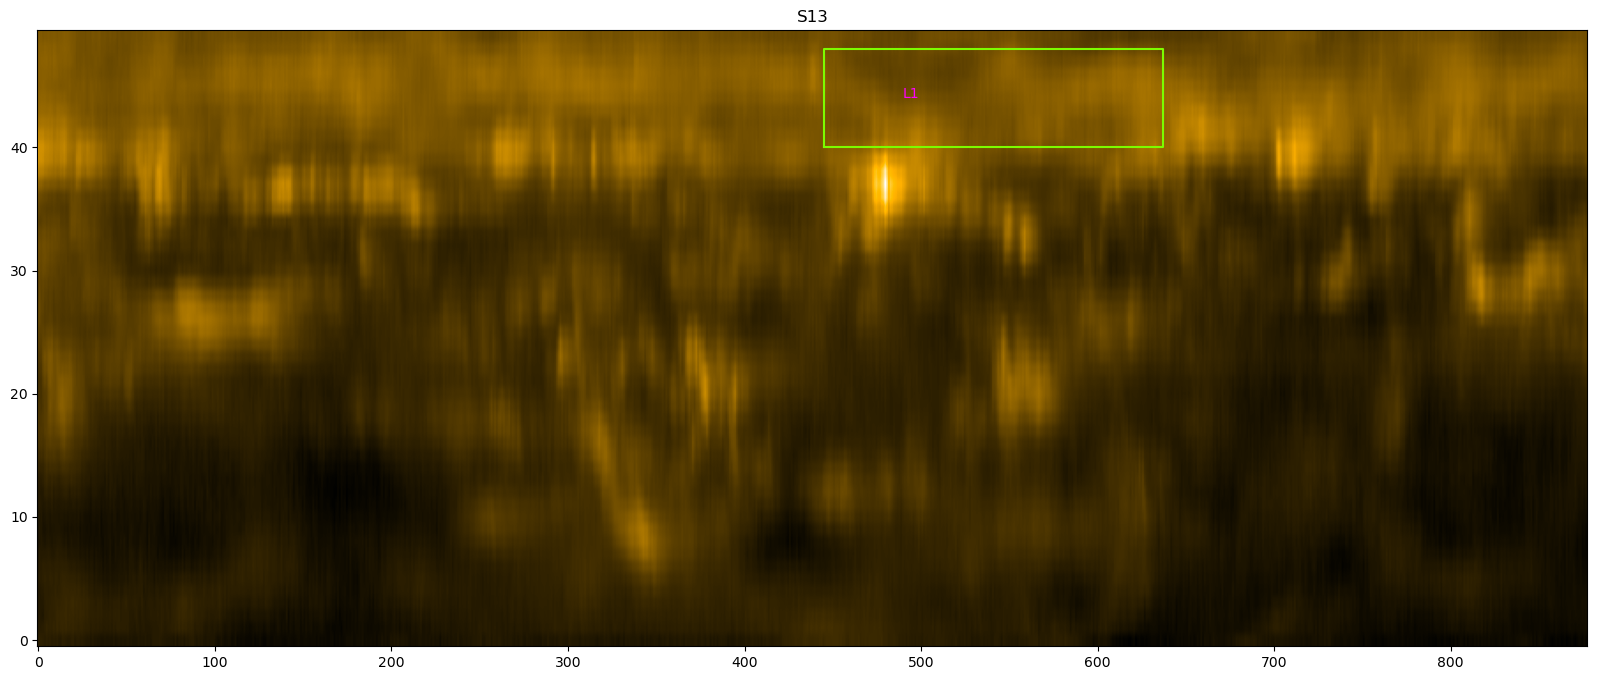

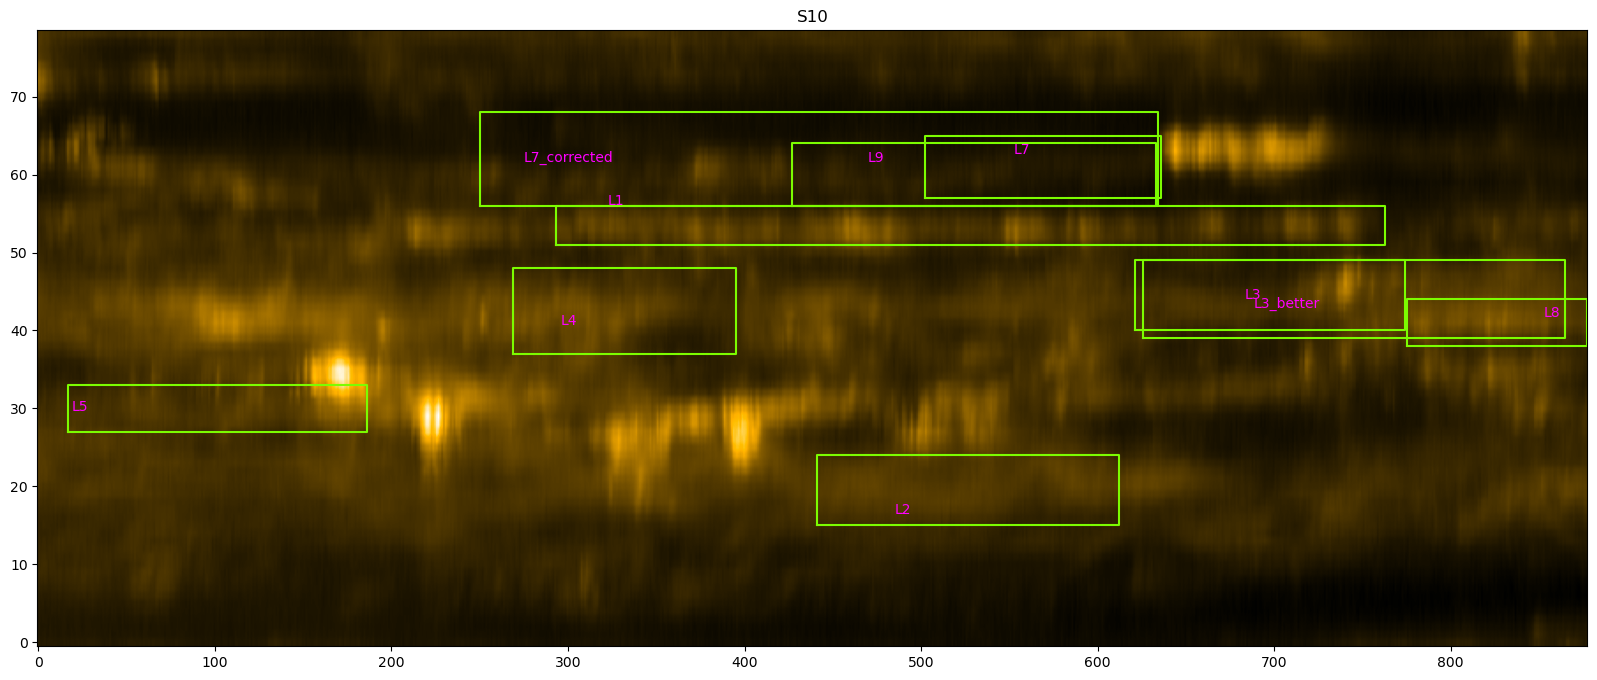

In [17]:
#make a loop_location.csv file remember that the x and y locations are switched
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import matplotlib
import sunpy.visualization.colormaps as cm

cmap=matplotlib.colormaps['sdoaia171']

slits_path="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R2/Slits"

slits=glob.glob(slits_path+"/S*")

for slit in slits:
    loops=glob.glob(slit+"/L*")
    loop_location_save=f"{slit}/loop_location.csv"
    dictionary={"Loop name":[],"left":[],"right":[],"bottom":[],"top":[]}
    for loop in loops:
        loop_loc=loop+"/box_location.csv"
        loc=pd.read_csv(loop_loc)
        left=loc['y'][0]
        right=loc['y'][1]
        bottom=loc['x'][0]
        top=loc['x'][1]
        dictionary['Loop name'].append(loop.split("/")[-1])
        dictionary['left'].append(left)
        dictionary['right'].append(right)
        dictionary['bottom'].append(bottom)
        dictionary['top'].append(top)
    # print(dictionary)
    xt_map_path=f"{slit}/xt_map.csv"
    xt_map=pd.read_csv(xt_map_path)
    fig= plt.figure(figsize=(20,8))
    plt.imshow(xt_map.T**0.04,cmap=cmap,origin='lower',aspect='auto')
    for i in range(len(dictionary['Loop name'])):
        plt.plot([dictionary['bottom'][i],dictionary['bottom'][i],dictionary['top'][i],dictionary['top'][i],dictionary['bottom'][i]],[dictionary['left'][i],dictionary['right'][i],dictionary['right'][i],dictionary['left'][i],dictionary['left'][i]],color='lawngreen')
        plt.text(dictionary['bottom'][i]*1.1,dictionary['left'][i]*1.1,dictionary['Loop name'][i],color='magenta')
    plt.title(slit.split("/")[-1])
    plt.show()
    # loop_loc_df=pd.DataFrame(dictionary)
    # loop_loc_df.to_csv(loop_location_save,index=False)

In [23]:
data_copy_path="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R2_bak/Slits"
data_save_path="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R2/Slits"

slits=glob.glob(data_copy_path+"/S*")
for slit in slits:
    slit_name=slit.split("/")[-1]
    cmd=f"cp {data_copy_path}/{slit_name}/loop_location.csv {data_save_path}/{slit_name}/"
    os.system(cmd)

In [51]:
# loop data cropping

slit_path="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits"

slits=glob.glob(slit_path+"/S*")

for slit in slits:
    loop_locations=pd.read_csv(slit+"/loop_location.csv",sep=',',header=0,names=['Loop name','left','right','bottom','top'])
    slit_name=slit.split("/")[-1]
    for i in range(len(loop_locations['Loop name'])):
        loop_name=loop_locations['Loop name'][i]
        left=loop_locations['left'][i]
        right=loop_locations['right'][i]
        bottom=loop_locations['bottom'][i]
        top=loop_locations['top'][i]
        cmd=f"mkdir {slit}/{loop_name}"
        xt_map_path=slit+"/xt_map.csv"
        xt_map=np.loadtxt(xt_map_path,delimiter=",",dtype=float)
        cropped_xt_map=xt_map[left:right,bottom:top]
        # fig=plt.figure(figsize=(15,6))
        # plt.imshow(cropped_xt_map.T**0.04,cmap=cmap,origin='lower',aspect='auto')
        # plt.title(f"{slit_name}/{loop_name}")
        # plt.show()
        loop_save_path=slit+f"/{loop_name}/"
        os.system(f"mkdir {loop_save_path}")
        box_loc={'x':[left,right],'y':[bottom,top]}
        box_loc_df=pd.DataFrame(box_loc)
        box_loc_df.to_csv(loop_save_path+"box_location.csv",index=False)
        np.savetxt(loop_save_path+"xt_map.csv",cropped_xt_map.T,delimiter=',')


        # os.system(cmd)
        # print(loop_name)


mkdir: cannot create directory ‘/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits/S4/L3/’: File exists
mkdir: cannot create directory ‘/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits/S4/L1/’: File exists
mkdir: cannot create directory ‘/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits/S4/L4/’: File exists
mkdir: cannot create directory ‘/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits/S4/L2/’: File exists
mkdir: cannot create directory ‘/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits/S4/L5/’: File exists
mkdir: cannot create

In [1]:
%matplotlib
# Fitting pipeline with errors
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import center_of_mass
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
import matplotlib
import sunpy.visualization.colormaps as cm
import os
import pandas as pd
import configparser as cfg
from uncertainties import ufloat

def gaussian(x,A,mu,sigma,const):
    return(A*np.exp(-(x-mu)**2/(2*sigma**2))+const)

def sinusoid(t,Am,P,phi,k,Ao):
    return(Am*np.sin(2*np.pi*t/P+phi)+k*t+Ao)

def find_peak(y,dy):
    # making the slice of compatible dimension
    y=y[::,0]
    dy=dy[::,0]
    l=len(y)
    x=np.arange(0,l)
    com=center_of_mass(y)[0]
    avg=np.average(y)
    maxi=np.argmax(y)
    #std=np.std(y)
    std=l/6
    try:
        parameters,pcov = curve_fit(gaussian, x, y,p0=[com,maxi,std,avg],sigma=dy,absolute_sigma=True)
        # parameters,pcov = curve_fit(gaussian, x, y,p0=[com,maxi,std,avg])
        fit_y=gaussian(x,parameters[0],parameters[1],parameters[2],parameters[3])
        index_max=np.argmax(fit_y)
        if 0<parameters[2]<1:
            parameters[2]=1
        if 1<parameters[2]<l and 0<parameters[1]<l-1:
            # return(index_max)
            return(parameters[1],parameters[2])
    except RuntimeError:
        pass

def chi_squared(expected,observed,sigma):
    chi=0
    for i in range(len(expected)):
        chi+=(expected[i]-observed[i])**2/(sigma[i])**2
    return(chi)

directory=input("Enter the path of the slits: ")+"/"

#directory="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R2/Slits/S9/L1/"

config_file=directory+"units.cfg"
# config_file="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/codes/test_data/S3/units.cfg"
config=cfg.ConfigParser()
config.read(config_file)

cadence=eval(config['PHYSICAL UNITS']['cadence'])
scale=eval(config['PHYSICAL UNITS']['scale'])

exposure=eval(config['IMAGE']['EXPOSURE'])

data = np.loadtxt(directory+"xt_map.csv",delimiter=",", dtype=float).T
data_err=np.sqrt(np.loadtxt(directory+"xt_map.csv",delimiter=",", dtype=float)*exposure*6.85+2).T
#data = np.loadtxt(directory+"xt_map_smooth_201.csv",delimiter=",", dtype=float).T

cmap=matplotlib.colormaps['sdoaia171']

#plt.imshow(data.T,origin='lower',cmap=cmap)
#plt.imshow(data_err.T,origin='lower',cmap=cmap)

toggle=1

while toggle==1:
    fig=plt.figure(figsize=(15,6))
    plt.imshow(data**0.04,origin='lower',cmap=cmap,aspect='auto')
    a=np.array((plt.ginput(2)))
    a=np.asarray(a,dtype='int')
    x=[a[0,0],a[1,0],a[1,0],a[0,0],a[0,0]]
    y=[a[0,1],a[0,1],a[1,1],a[1,1],a[0,1]]
    left=min(a[0,1],a[1,1])
    right=max(a[0,1],a[1,1])
    top=max(a[0,0],a[1,0])
    bottom=min(a[0,0],a[1,0])
    mid_frame=int((right+left)/2)
    plt.plot(x,y,c='cyan')
    plt.show()
    data_osci=data[left:right,bottom:top]
    data_osci_err=data_err[left:right,bottom:top]
    plt.imshow(data_osci,origin='lower',cmap=cmap,aspect='auto')
    plt.show()


    # breaking the xt-map in slices then fitting gaussian on each slice
    slices=np.hsplit(data_osci,len(data_osci[0]))
    slices_err=np.hsplit(data_osci_err,len(data_osci_err[0]))
    peak=[]
    peak_err=[]
    t=[]

    for i in range(len(slices)):
        peak_data=find_peak(slices[i],slices_err[i])
        if peak_data!=None:
            t.append(i)
            peak.append(peak_data[0])
            # peak_err.append(peak_data[1])
            peak_err.append(peak_data[1])
            plt.show()
    # print(peak,peak_err)
    # plt.errorbar(t,peak,yerr=peak_err,fmt='o')
    # plt.show()
    guess_amplitude=np.max(peak)-np.mean(peak)
    #periods=np.linspace(eval(input("Enter period start: ")),eval(input("Enter period end: ")),1000)
    periods=np.linspace(1,2000,1000)
    pgram=lombscargle(t,peak,periods)
    # plt.plot(periods,pgram)
    # plt.show()
    guess_period=periods[np.argmax(pgram)]
    # guess_period=280
    guess_phase=0
    guess_offset=np.mean(peak)
    guess_drift=(peak[-1]-peak[0])/len(peak)
    guess=[guess_amplitude,guess_period,guess_phase,guess_drift,guess_offset]
    t_fit=np.linspace(t[0],t[-1],10*len(t))

    try:
        sine_param,sine_cov=curve_fit(sinusoid,t,peak,p0=guess,sigma=peak_err,absolute_sigma=True)
        sine_err=np.sqrt(np.diag(sine_cov))

        Am=ufloat(sine_param[0],sine_err[0])*scale
        P=ufloat(sine_param[1],sine_err[1])*cadence
        phi=ufloat(sine_param[2],sine_err[2])
        k=ufloat(sine_param[3],sine_err[3])*scale/cadence
        Ao=ufloat(sine_param[3],sine_err[3])*scale

    except RuntimeError:
        print("Sinusoidal fit did not converge")

    fig=plt.figure(figsize=(15,6))
    plt.imshow(data,origin='lower',cmap=cmap,aspect='auto')
    plt.errorbar(t,peak,yerr=peak_err,color='cyan',markersize=5,fmt='o',lw=0.6,capsize=3)
    try:
        sine=sinusoid(t_fit,sine_param[0],sine_param[1],sine_param[2],sine_param[3],sine_param[4])
        observed=sinusoid(np.array(t),sine_param[0],sine_param[1],sine_param[2],sine_param[3],sine_param[4])
        plt.plot(t_fit,sine,color='magenta',linewidth=1)
        chi_sq=chi_squared(peak,observed,peak_err)
        # plt.title(r"$A_m=$%.3f km, $P=$%.3f s, $\phi=$%.3f, $k=$%.3f km/s, $\chi^2$=%.3f"%(abs(sine_param[0]*scale),sine_param[1]*cadence,sine_param[2],sine_param[3]*scale/cadence,chi_sq))
        plt.title(rf"$A_m=${Am:.3f} km, $P=${P:.3f} s, $\phi=${phi:.3f}, $k=${k:.3f} km/s, $\chi^2$={chi_sq:.3f}")
    #    plt.savefig(directory+f"xt_map_fit.png",dpi=300)
    except NameError:
        print("Can't plot Sinusoidal parameters not found!")
    plt.show()

        # toggle_1=int(input("Enter 1 to save oscillation, 0 to skip: "))
        # if toggle_1==0:
        #     pass
        # if toggle_1==1:
        #     loop_name=input("Enter loop name: ")
        #     #loop_name="L"+f"{loop_number}"
        #     save_path=directory+loop_name+"/"
        #     os.makedirs(save_path)
        #     np.savetxt(save_path+"xt_map.csv",data_osci,delimiter=',')
        #     df_loop_center=pd.DataFrame({"Frame":t,"Peak center":peak})
        #     df_loop_center.to_csv(save_path+"loop_center.csv",index=False)
        #     df_box_loc=pd.DataFrame({"x":[left,right],"y":[bottom,top]})
        #     df_box_loc.to_csv(save_path+"box_location.csv",index=False)
        #     fig.savefig(save_path+"oscillation.png",dpi=300)
        #     df_oscillation_parameter=pd.DataFrame({"Amplitude [km]":[sine_param[0]*scale],"Period [s]":[sine_param[1]*cadence],"Drift Velocity [km/s]":[sine_param[3]*scale/cadence],"Phase":[sine_param[2]],"Off-set":[sine_param[4]*scale],"Chi-squared [pixel]":[chi_sq]})
        #     df_oscillation_parameter.to_csv(save_path+"oscillation_parameter.csv",index=False)
        # toggle=int(input("Enter 1 to re-run the code, 0 to end the code: "))

Using matplotlib backend: <object object at 0x7f58923d3df0>


/home/vampy/miniconda3/envs/solar/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


: 

: 

In [6]:
from uncertainties import ufloat
import numpy as np
import pandas as pd

df=pd.read_csv("/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/solo_L2_EUI-HRIEUV174-IMAGE_2022-03-17T03:18:00_2022-03-17T04:02:00/R1/Slits/S1/L23_new/oscillation_parameter.csv")

a=df.to_numpy()

In [10]:
c=ufloat(a[0][0])

/tmp/ipykernel_155838/3909162957.py:1: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  c=ufloat(a[0][0])


In [14]:
# to plot the selected 

120.0